In [2]:
from huggingface_hub import login
login(new_session=True)

In [4]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")
model = AutoModelForCausalLM.from_pretrained("Qwen/Qwen2.5-1.5B-Instruct")
def get_structured_reasoning(prompt):
    reasoning_prompt = f"""
You are an expert reasoning assistant.
Given a problem, break down your thinking into clear numbered steps, then give the final answer.
Respond ONLY in JSON with the keys: "steps" (list of strings) and "answer" (string).

Problem: {prompt}
"""
    messages = [{"role": "user", "content": reasoning_prompt}]
    inputs = tokenizer.apply_chat_template(
    messages,
    add_generation_prompt=True,
    tokenize=True,
    return_dict=True,
    return_tensors="pt",
    ).to(model.device)

    outputs = model.generate(**inputs, max_new_tokens=256)#token 256 for full output room
    print(tokenizer.decode(outputs[0][inputs["input_ids"].shape[-1]:]))
# Example
prompt = """Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?"""
print(get_structured_reasoning(prompt))

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

2025-09-18 20:30:17.451779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758227417.693389      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758227417.761072      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/3.09G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/242 [00:00<?, ?B/s]

```json
{
  "steps": [
    {
      "step": "Calculate the number of clips sold in May."
    },
    {
      "step": "Add the number of clips sold in April and May."
    }
  ],
  "answer": "120"
}
```<|im_end|>
None


In [5]:
from datasets import load_dataset
ds = load_dataset("gsm8k", "main")



README.md: 0.00B [00:00, ?B/s]

main/train-00000-of-00001.parquet:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

main/test-00000-of-00001.parquet:   0%|          | 0.00/419k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [6]:
print(ds["train"][0])

{'question': 'Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?', 'answer': 'Natalia sold 48/2 = <<48/2=24>>24 clips in May.\nNatalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May.\n#### 72'}


In [7]:
from datasets import load_dataset
import json

# 1. Load GSM8K (main split)
dataset = load_dataset("gsm8k", "main")
def parse_answer_to_trace(answer_text):
    """Convert GSM8K reasoning text into ACT-R trace style steps."""
    # Remove trailing "#### ..." part
    clean_answer = answer_text.split("####")[0].strip()

    # Split by ". " or "\n" into steps
    parts = [p.strip() for p in re.split(r'\. |\n', clean_answer) if p.strip()]

    steps = []
    timestamp = 0.005
    for part in parts:
        steps.append(f"{timestamp:.3f}: {part}")
        timestamp += 0.005
    return steps


# 2. Convert dataset
actr_data = []
for ex in dataset["train"]:
    prompt = ex["question"].strip()
    answer_text = ex["answer"].strip()

    # Extract final number from answer (last number in text)
    import re
    numbers = re.findall(r"-?\d+\.?\d*", answer_text)
    final_answer = numbers[-1] if numbers else ""

    trace_events = parse_answer_to_trace(answer_text)

    actr_data.append({
        "prompt": prompt,
        "trace_events": trace_events,
        "label": final_answer
    })

# 3. Save to JSON
with open("gsm8k_actr.json", "w") as f:
    json.dump(actr_data, f, indent=2)

print(f"Saved {len(actr_data)}gsm8k_actr.json")
print("Example entry:")
print(json.dumps(actr_data[0], indent=2))


Saved 7473gsm8k_actr.json
Example entry:
{
  "prompt": "Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How many clips did Natalia sell altogether in April and May?",
  "trace_events": [
    "0.005: Natalia sold 48/2 = <<48/2=24>>24 clips in May.",
    "0.010: Natalia sold 48+24 = <<48+24=72>>72 clips altogether in April and May."
  ],
  "label": "72"
}


Loading data...
Loaded 7473 examples with 10 classes
Label distribution: [837 768 650 755 732 747 785 705 753 741]
Label range: 0 to 9
Label type: <class 'numpy.ndarray'>
Label dtype: int64
Unique labels: [0 1 2 3 4 5 6 7 8 9]
Label range: 0 to 9
Any NaN values: False
Any infinite values: False
Building ACT-R embeddings...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/234 [00:00<?, ?it/s]

ACT-R embeddings shape: (7473, 396)
Building Qwen embeddings...
Processed 4/7473 prompts
Processed 1004/7473 prompts
Processed 2004/7473 prompts
Processed 3004/7473 prompts
Processed 4004/7473 prompts
Processed 5004/7473 prompts
Processed 6004/7473 prompts
Processed 7004/7473 prompts
Qwen embeddings shape: (7473, 1536)

TRAINING BOTH MODELS FOR COMPARISON

Training BASELINE MODEL (Qwen Only)
Epoch 0: Loss = 2.3101, Val Acc = 0.1492
Epoch 5: Loss = 2.2349, Val Acc = 0.1853
Epoch 10: Loss = 2.1305, Val Acc = 0.1860
Epoch 15: Loss = 2.0296, Val Acc = 0.2087
Epoch 20: Loss = 1.9175, Val Acc = 0.2154
Epoch 25: Loss = 1.7936, Val Acc = 0.2314
Epoch 30: Loss = 1.6801, Val Acc = 0.2301
Epoch 35: Loss = 1.5698, Val Acc = 0.2227
Epoch 40: Loss = 1.4406, Val Acc = 0.2154
Epoch 45: Loss = 1.3399, Val Acc = 0.2154
BASELINE - Final Test Accuracy: 0.2114
BASELINE - Final Test F1: 0.2052

Training NCA MODEL (Qwen + ACT-R Fusion)
Epoch 0: Loss = 2.3046, Val Acc = 0.1010
Epoch 5: Loss = 2.2652, Val Acc 

Traceback (most recent call last):
  File "/tmp/ipykernel_36/2624844941.py", line 700, in main
    trainer.plot_comparison_results(baseline_results, nca_results)
  File "/tmp/ipykernel_36/2624844941.py", line 632, in plot_comparison_results
    im3 = axes[1,2].imshow(cm_diff, interpolation='nearest', cmap=plt.cm.RdYlBu, center=0)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/__init__.py", line 1446, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/axes/_axes.py", line 5656, in imshow
    im = mimage.AxesImage(self, cmap=cmap, norm=norm,
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/matplotlib/_api/deprecation.py", line 454, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^

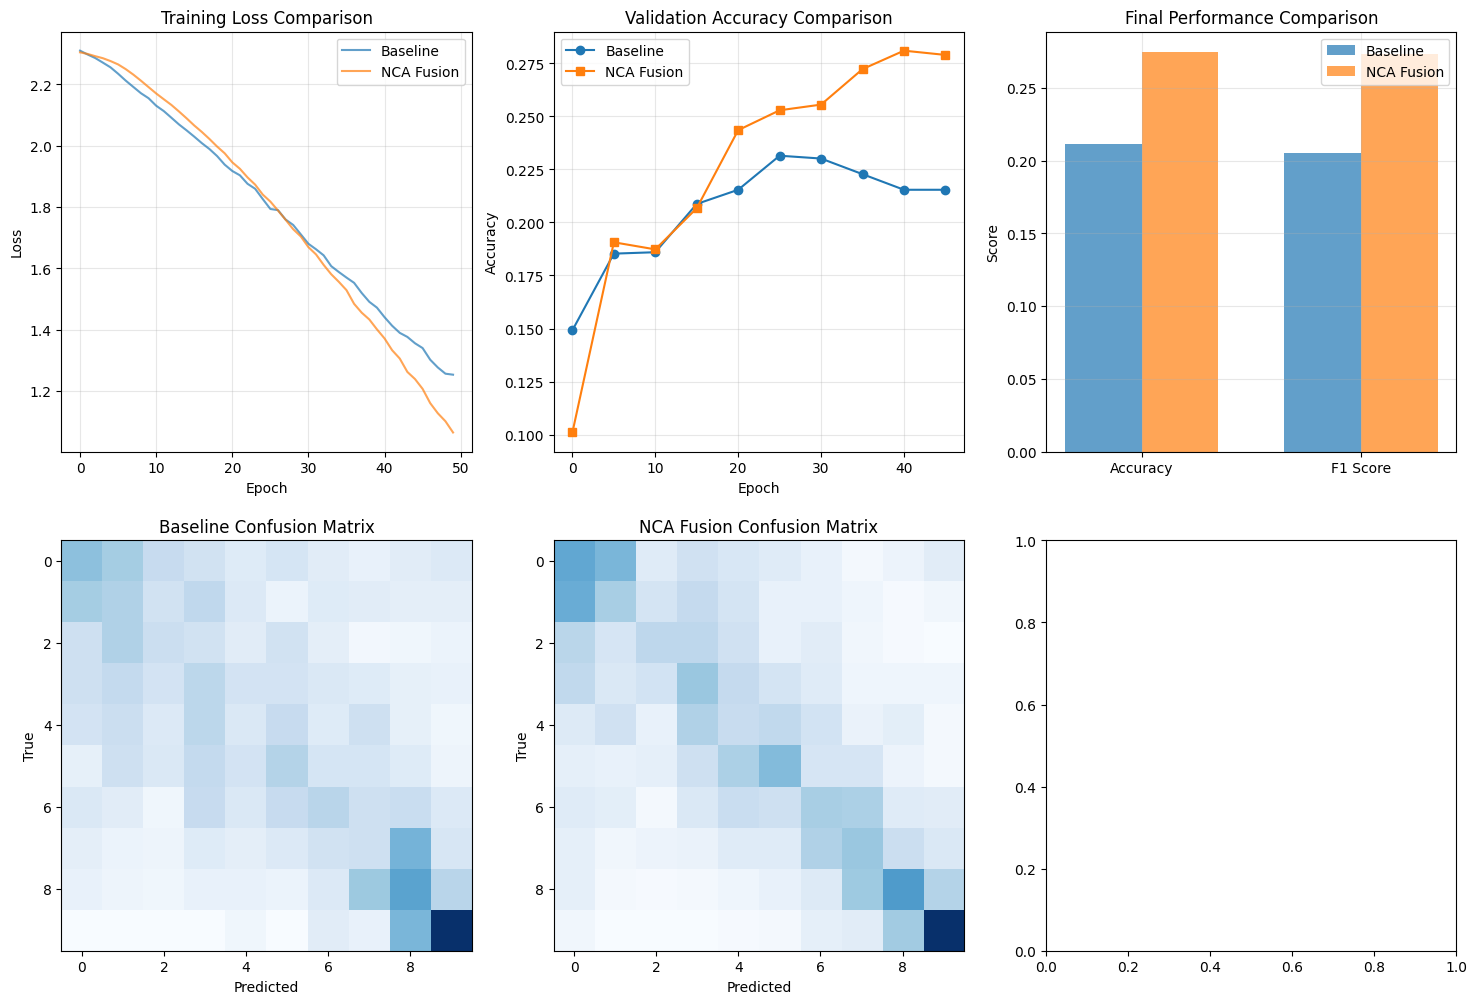

In [9]:
import json
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import AutoTokenizer, AutoModelForCausalLM
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Configuration
class Config:
    DATA_FILE = "/kaggle/working/gsm8k_actr.json"
    SENTENCE_MODEL = "all-MiniLM-L6-v2"
    LLM = "Qwen/Qwen2.5-1.5B-Instruct"
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    RANDOM_SEED = 42

    # Training parameters
    BATCH_SIZE = 16
    LEARNING_RATE = 1e-3
    EPOCHS = 50
    DROPOUT_RATE = 0.3

class EnhancedACTRProcessor:
    def __init__(self):
        self.math_patterns = [
            r'(\d+\.?\d*)\s*\+\s*(\d+\.?\d*)',  # addition
            r'(\d+\.?\d*)\s*-\s*(\d+\.?\d*)',   # subtraction
            r'(\d+\.?\d*)\s*\*\s*(\d+\.?\d*)',  # multiplication
            r'(\d+\.?\d*)\s*/\s*(\d+\.?\d*)',   # division
        ]

    def extract_features(self, trace_events):
        """Extract enhanced features from ACT-R traces"""
        features = {}

        # Basic features
        features['num_steps'] = len(trace_events)
        features['total_text_length'] = sum(len(step) for step in trace_events)
        features['avg_step_length'] = features['total_text_length'] / max(1, features['num_steps'])

        # Mathematical operation features
        text = ' '.join(trace_events)
        features['additions'] = len(re.findall(r'\+', text))
        features['subtractions'] = len(re.findall(r'-', text))
        features['multiplications'] = len(re.findall(r'\*|×', text))
        features['divisions'] = len(re.findall(r'/|÷', text))

        # Number features
        numbers = re.findall(r'-?\d+\.?\d*', text)
        if numbers:
            nums = [float(n) for n in numbers]
            features['num_count'] = len(nums)
            features['num_mean'] = np.mean(nums)
            features['num_max'] = max(nums)
            features['num_min'] = min(nums)
            features['num_range'] = features['num_max'] - features['num_min']
        else:
            features['num_count'] = features['num_mean'] = 0
            features['num_max'] = features['num_min'] = features['num_range'] = 0

        return np.array(list(features.values()))

class BaselineModel(nn.Module):
    """Baseline Qwen-only model"""
    def __init__(self, llm_dim, num_classes, dropout=0.3):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(llm_dim, 256),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, llm_emb):
        return self.classifier(llm_emb)

class NCAFusionModel(nn.Module):
    """NCA Fusion model (Qwen + ACT-R)"""
    def __init__(self, llm_dim, actr_dim, num_classes, dropout=0.3):
        super().__init__()

        # Projection layers
        self.llm_proj = nn.Linear(llm_dim, 128)
        self.actr_proj = nn.Linear(actr_dim, 128)

        # Attention weights
        self.attention_weights = nn.Parameter(torch.randn(2))

        # Classification head
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, llm_emb, actr_emb):
        # Project embeddings
        llm_proj = torch.relu(self.llm_proj(llm_emb))
        actr_proj = torch.relu(self.actr_proj(actr_emb))

        # Apply attention weights
        weights = torch.softmax(self.attention_weights, dim=0)
        weighted_llm = weights[0] * llm_proj
        weighted_actr = weights[1] * actr_proj

        # Concatenate
        fused = torch.cat([weighted_llm, weighted_actr], dim=1)

        return self.classifier(fused)

class ComparisonTrainer:
    def __init__(self, config):
        self.config = config
        self.actr_processor = EnhancedACTRProcessor()
        torch.manual_seed(config.RANDOM_SEED)
        np.random.seed(config.RANDOM_SEED)
        self.attention_weights = None # Initialize attention weights attribute

    def load_data(self):
        """Load and preprocess data with proper label handling"""
        print("Loading data...")
        with open(self.config.DATA_FILE, "r") as f:
            data = json.load(f)

        # Process labels
        labels = []
        valid_data = []

        for d in data:
            try:
                label_text = str(d["label"]).strip()
                # Extract number from label
                numbers = re.findall(r'-?\d+\.?\d*', label_text)
                if numbers:
                    labels.append(float(numbers[-1]))
                    valid_data.append(d)
            except:
                continue

        labels = np.array(labels)
        prompts = [d["prompt"] for d in valid_data]

        # FIXED: Proper label processing
        if len(np.unique(labels)) > 50:
            # Use quantile-based binning to ensure balanced classes
            n_bins = 10
            try:
                labels_binned = pd.qcut(labels, q=n_bins, labels=False, duplicates='drop')

                # Handle any NaN values - convert to pandas Series first
                if hasattr(labels_binned, 'fillna'):
                    labels_binned = labels_binned.fillna(0)
                else:
                    # It's a numpy array, handle NaN differently
                    labels_binned = np.nan_to_num(labels_binned, nan=0)

                labels = labels_binned.astype(int)

            except Exception as e:
                print(f"qcut failed: {e}, falling back to uniform binning...")
                # Fallback to uniform binning
                labels_binned, bin_edges = pd.cut(labels, bins=n_bins, labels=False, retbins=True)
                if hasattr(labels_binned, 'fillna'):
                    labels_binned = labels_binned.fillna(0)
                else:
                    labels_binned = np.nan_to_num(labels_binned, nan=0)
                labels = labels_binned.astype(int)

            # Double-check: ensure all labels are in valid range [0, num_classes-1]
            num_classes = len(np.unique(labels))
            labels = np.clip(labels, 0, num_classes - 1)
        else:
            # Use LabelEncoder for safer encoding
            le = LabelEncoder()
            labels = le.fit_transform(labels)

        print(f"Loaded {len(valid_data)} examples with {len(np.unique(labels))} classes")
        print(f"Label distribution: {np.bincount(labels)}")
        print(f"Label range: {labels.min()} to {labels.max()}")

        return valid_data, prompts, labels

    def build_actr_embeddings(self, examples):
        """Build ACT-R embeddings with both text and features"""
        print("Building ACT-R embeddings...")

        # Text embeddings
        st_model = SentenceTransformer(self.config.SENTENCE_MODEL)
        texts = [' '.join(ex['trace_events']) for ex in examples]
        text_embeddings = st_model.encode(texts, show_progress_bar=True)

        # Feature embeddings
        feature_embeddings = []
        for ex in examples:
            features = self.actr_processor.extract_features(ex['trace_events'])
            feature_embeddings.append(features)

        feature_embeddings = np.array(feature_embeddings)

        # Combine text and features
        combined = np.concatenate([text_embeddings, feature_embeddings], axis=1)
        print(f"ACT-R embeddings shape: {combined.shape}")
        return combined

    def build_llm_embeddings(self, prompts):
        """Build Qwen embeddings with improved memory management"""
        print("Building Qwen embeddings...")

        # Load tokenizer and model
        tokenizer = AutoTokenizer.from_pretrained(self.config.LLM)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token

        model = AutoModelForCausalLM.from_pretrained(
            self.config.LLM,
            torch_dtype=torch.float16 if self.config.DEVICE == "cuda" else torch.float32,
            device_map="auto"
        )
        model.eval()

        embeddings = []
        batch_size = 4

        with torch.no_grad():
            for i in range(0, len(prompts), batch_size):
                batch = prompts[i:i+batch_size]

                # Tokenize
                inputs = tokenizer(
                    batch,
                    return_tensors="pt",
                    padding=True,
                    truncation=True,
                    max_length=512
                ).to(model.device)

                # Get embeddings
                outputs = model(**inputs, output_hidden_states=True)
                last_hidden = outputs.hidden_states[-1].mean(dim=1) # Corrected attribute name
                embeddings.append(last_hidden.cpu().numpy())

                # Clear GPU cache periodically
                if i % 100 == 0:
                    torch.cuda.empty_cache()

                if i % 1000 == 0:
                    print(f"Processed {min(i+batch_size, len(prompts))}/{len(prompts)} prompts")

        embeddings = np.vstack(embeddings)
        print(f"Qwen embeddings shape: {embeddings.shape}")

        # Clear model from memory
        del model
        torch.cuda.empty_cache()

        return embeddings

    def train_baseline_model(self, llm_emb, labels):
        """Train baseline Qwen-only model"""
        print("\n" + "="*50)
        print("Training BASELINE MODEL (Qwen Only)")
        print("="*50)

        # Prepare data
        scaler = StandardScaler()
        llm_emb_scaled = scaler.fit_transform(llm_emb)

        # Split data
        indices = np.arange(len(labels))
        train_idx, test_idx = train_test_split(
            indices, test_size=0.2, random_state=self.config.RANDOM_SEED, stratify=labels
        )

        # Create datasets
        X_train = torch.FloatTensor(llm_emb_scaled[train_idx]).to(self.config.DEVICE)
        y_train = torch.LongTensor(labels[train_idx]).to(self.config.DEVICE)
        X_test = torch.FloatTensor(llm_emb_scaled[test_idx]).to(self.config.DEVICE)
        y_test = torch.LongTensor(labels[test_idx]).to(self.config.DEVICE)

        # Create model
        num_classes = len(np.unique(labels))
        model = BaselineModel(llm_emb.shape[1], num_classes, self.config.DROPOUT_RATE).to(self.config.DEVICE)

        # Training setup
        optimizer = optim.Adam(model.parameters(), lr=self.config.LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        train_losses = []
        val_accuracies = []

        for epoch in range(self.config.EPOCHS):
            model.train()
            optimizer.zero_grad()

            outputs = model(X_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_losses.append(loss.item())

            # Validation
            if epoch % 5 == 0:
                model.eval()
                with torch.no_grad():
                    val_outputs = model(X_test)
                    val_preds = torch.argmax(val_outputs, dim=1)
                    val_acc = (val_preds == y_test).float().mean().item()
                    val_accuracies.append(val_acc)
                    print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Val Acc = {val_acc:.4f}")

        # Final evaluation
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_preds = torch.argmax(test_outputs, dim=1)
            test_acc = (test_preds == y_test).float().mean().item()
            test_f1 = f1_score(y_test.cpu(), test_preds.cpu(), average='macro')

        print(f"BASELINE - Final Test Accuracy: {test_acc:.4f}")
        print(f"BASELINE - Final Test F1: {test_f1:.4f}")

        return {
            'model': model,
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
            'test_accuracy': test_acc,
            'test_f1': test_f1,
            'test_predictions': test_preds.cpu().numpy(),
            'test_true': y_test.cpu().numpy(),
            'test_indices': test_idx
        }

    def train_nca_model(self, llm_emb, actr_emb, labels):
        """Train NCA fusion model"""
        print("\n" + "="*50)
        print("Training NCA MODEL (Qwen + ACT-R Fusion)")
        print("="*50)

        # Prepare data
        scaler_llm = StandardScaler()
        scaler_actr = StandardScaler()

        llm_emb = scaler_llm.fit_transform(llm_emb)
        actr_emb = scaler_actr.fit_transform(actr_emb)

        # Split data
        indices = np.arange(len(labels))
        train_idx, test_idx = train_test_split(
            indices, test_size=0.2, random_state=self.config.RANDOM_SEED, stratify=labels
        )

        # Create datasets
        X_llm_train = torch.FloatTensor(llm_emb[train_idx]).to(self.config.DEVICE)
        X_actr_train = torch.FloatTensor(actr_emb[train_idx]).to(self.config.DEVICE)
        y_train = torch.LongTensor(labels[train_idx]).to(self.config.DEVICE)

        X_llm_test = torch.FloatTensor(llm_emb[test_idx]).to(self.config.DEVICE)
        X_actr_test = torch.FloatTensor(actr_emb[test_idx]).to(self.config.DEVICE)
        y_test = torch.LongTensor(labels[test_idx]).to(self.config.DEVICE)

        # Create model
        num_classes = len(np.unique(labels))
        model = NCAFusionModel(
            llm_emb.shape[1],
            actr_emb.shape[1],
            num_classes,
            self.config.DROPOUT_RATE
        ).to(self.config.DEVICE)

        # Training setup
        optimizer = optim.Adam(model.parameters(), lr=self.config.LEARNING_RATE)
        criterion = nn.CrossEntropyLoss()

        # Training loop
        train_losses = []
        val_accuracies = []

        for epoch in range(self.config.EPOCHS):
            model.train()
            optimizer.zero_grad()

            outputs = model(X_llm_train, X_actr_train)
            loss = criterion(outputs, y_train)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_losses.append(loss.item())

            # Validation
            if epoch % 5 == 0:
                model.eval()
                with torch.no_grad():
                    val_outputs = model(X_llm_test, X_actr_test)
                    val_preds = torch.argmax(val_outputs, dim=1)
                    val_acc = (val_preds == y_test).float().mean().item()
                    val_accuracies.append(val_acc)
                    print(f"Epoch {epoch}: Loss = {loss.item():.4f}, Val Acc = {val_acc:.4f}")

        # Final evaluation
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_llm_test, X_actr_test)
            test_preds = torch.argmax(test_outputs, dim=1)
            test_acc = (test_preds == y_test).float().mean().item()
            test_f1 = f1_score(y_test.cpu(), test_preds.cpu(), average='macro')

        print(f"NCA - Final Test Accuracy: {test_acc:.4f}")
        print(f"NCA - Final Test F1: {test_f1:.4f}")

        return {
            'model': model,
            'train_losses': train_losses,
            'val_accuracies': val_accuracies,
            'test_accuracy': test_acc,
            'test_f1': test_f1,
            'test_predictions': test_preds.cpu().numpy(),
            'test_true': y_test.cpu().numpy(),
            'test_indices': test_idx,
            'attention_weights': torch.softmax(model.attention_weights, dim=0).detach().cpu().numpy()
        }

    def detailed_comparison_analysis(self, baseline_results, nca_results, valid_data, labels):
        """Generate detailed comparison analysis"""
        print("\n" + "="*60)
        print("DETAILED COMPARISON ANALYSIS")
        print("="*60)

        comparison_data = []

        # Overall comparison
        overall_comparison = {
            'metric': 'Overall',
            'baseline_accuracy': baseline_results['test_accuracy'],
            'nca_accuracy': nca_results['test_accuracy'],
            'accuracy_improvement': nca_results['test_accuracy'] - baseline_results['test_accuracy'],
            'baseline_f1': baseline_results['test_f1'],
            'nca_f1': nca_results['test_f1'],
            'f1_improvement': nca_results['test_f1'] - baseline_results['test_f1'],
            'sample_count': len(baseline_results['test_true'])
        }
        comparison_data.append(overall_comparison)

        # Per-class analysis
        baseline_preds = baseline_results['test_predictions']
        nca_preds = nca_results['test_predictions']
        true_labels = baseline_results['test_true']

        for class_idx in range(len(np.unique(labels))):
            class_mask = (true_labels == class_idx)
            if np.sum(class_mask) > 0:
                baseline_class_acc = (baseline_preds[class_mask] == true_labels[class_mask]).mean()
                nca_class_acc = (nca_preds[class_mask] == true_labels[class_mask]).mean()

                class_comparison = {
                    'metric': f'Class_{class_idx}',
                    'baseline_accuracy': baseline_class_acc,
                    'nca_accuracy': nca_class_acc,
                    'accuracy_improvement': nca_class_acc - baseline_class_acc,
                    'baseline_f1': 0,  # Would need per-class F1 calculation
                    'nca_f1': 0,
                    'f1_improvement': 0,
                    'sample_count': np.sum(class_mask)
                }
                comparison_data.append(class_comparison)

        # Problem complexity analysis
        test_indices = baseline_results['test_indices']
        test_examples = [valid_data[i] for i in test_indices]

        for example_idx, (example, baseline_pred, nca_pred, true_label) in enumerate(
            zip(test_examples, baseline_preds, nca_preds, true_labels)
        ):
            # Calculate problem complexity metrics
            trace_text = ' '.join(example['trace_events'])
            complexity_metrics = {
                'example_id': example_idx,
                'true_label': true_label,
                'baseline_prediction': baseline_pred,
                'nca_prediction': nca_pred,
                'baseline_correct': (baseline_pred == true_label),
                'nca_correct': (nca_pred == true_label),
                'improvement': int(nca_pred == true_label) - int(baseline_pred == true_label), # FIXED: Convert bool to int
                'num_steps': len(example['trace_events']),
                'trace_length': len(trace_text),
                'num_operations': len(re.findall(r'[+\-*/]', trace_text)),
                'num_numbers': len(re.findall(r'\d+', trace_text)),
                'prompt_length': len(example['prompt'])
            }
            comparison_data.append(complexity_metrics)

        return comparison_data

    def save_comparison_csv(self, comparison_data, filename="nca_vs_baseline_comparison.csv"):
        """Save detailed comparison to CSV"""
        print(f"\nSaving comparison analysis to {filename}...")

        # Separate overall/class metrics from individual examples
        summary_data = [d for d in comparison_data if 'metric' in d]
        example_data = [d for d in comparison_data if 'example_id' in d]

        # Save summary comparison
        summary_df = pd.DataFrame(summary_data)
        summary_filename = filename.replace('.csv', '_summary.csv')
        summary_df.to_csv(summary_filename, index=False)
        print(f"Summary saved to: {summary_filename}")

        # Save detailed example-level analysis
        example_df = pd.DataFrame(example_data)
        detail_filename = filename.replace('.csv', '_detailed.csv')
        example_df.to_csv(detail_filename, index=False)
        print(f"Detailed analysis saved to: {detail_filename}")

        # Print key insights
        print("\n" + "="*50)
        print("KEY INSIGHTS")
        print("="*50)

        overall = summary_data[0]
        print(f"Overall Accuracy Improvement: {overall['accuracy_improvement']:.4f}")
        print(f"Overall F1 Improvement: {overall['f1_improvement']:.4f}")

        if self.attention_weights is not None:
             print(f"Attention Weights - Qwen: {self.attention_weights[0]:.3f}, ACT-R: {self.attention_weights[1]:.3f}")


        # Analysis of improvements
        improvements = example_df['improvement'].values
        print(f"Examples where NCA helped: {np.sum(improvements > 0)}")
        print(f"Examples where NCA hurt: {np.sum(improvements < 0)}")
        print(f"Examples with no change: {np.sum(improvements == 0)}")

        # Complexity analysis
        if len(example_data) > 0:
            improved_examples = example_df[example_df['improvement'] > 0]
            hurt_examples = example_df[example_df['improvement'] < 0]

            if len(improved_examples) > 0:
                print(f"Avg steps in improved examples: {improved_examples['num_steps'].mean():.2f}")
                print(f"Avg operations in improved examples: {improved_examples['num_operations'].mean():.2f}")

            if len(hurt_examples) > 0:
                print(f"Avg steps in hurt examples: {hurt_examples['num_steps'].mean():.2f}")
                print(f"Avg operations in hurt examples: {hurt_examples['num_operations'].mean():.2f}")

        return summary_df, example_df

    def plot_comparison_results(self, baseline_results, nca_results):
        """Plot comprehensive comparison results"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Training loss comparison
        axes[0,0].plot(baseline_results['train_losses'], label='Baseline', alpha=0.7)
        axes[0,0].plot(nca_results['train_losses'], label='NCA Fusion', alpha=0.7)
        axes[0,0].set_title('Training Loss Comparison')
        axes[0,0].set_xlabel('Epoch')
        axes[0,0].set_ylabel('Loss')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)

        # Validation accuracy comparison
        baseline_epochs = range(0, len(baseline_results['train_losses']), 5)
        nca_epochs = range(0, len(nca_results['train_losses']), 5)

        axes[0,1].plot(baseline_epochs[:len(baseline_results['val_accuracies'])],
                      baseline_results['val_accuracies'], label='Baseline', marker='o')
        axes[0,1].plot(nca_epochs[:len(nca_results['val_accuracies'])],
                      nca_results['val_accuracies'], label='NCA Fusion', marker='s')
        axes[0,1].set_title('Validation Accuracy Comparison')
        axes[0,1].set_xlabel('Epoch')
        axes[0,1].set_ylabel('Accuracy')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)

        # Final metrics comparison
        metrics = ['Accuracy', 'F1 Score']
        baseline_scores = [baseline_results['test_accuracy'], baseline_results['test_f1']]
        nca_scores = [nca_results['test_accuracy'], nca_results['test_f1']]

        x = np.arange(len(metrics))
        width = 0.35

        axes[0,2].bar(x - width/2, baseline_scores, width, label='Baseline', alpha=0.7)
        axes[0,2].bar(x + width/2, nca_scores, width, label='NCA Fusion', alpha=0.7)
        axes[0,2].set_title('Final Performance Comparison')
        axes[0,2].set_ylabel('Score')
        axes[0,2].set_xticks(x)
        axes[0,2].set_xticklabels(metrics)
        axes[0,2].legend()
        axes[0,2].grid(True, alpha=0.3)

        # Confusion matrices
        from sklearn.metrics import confusion_matrix

        # Baseline confusion matrix
        cm_baseline = confusion_matrix(baseline_results['test_true'], baseline_results['test_predictions'])
        im1 = axes[1,0].imshow(cm_baseline, interpolation='nearest', cmap=plt.cm.Blues)
        axes[1,0].set_title('Baseline Confusion Matrix')
        axes[1,0].set_xlabel('Predicted')
        axes[1,0].set_ylabel('True')

        # NCA confusion matrix
        cm_nca = confusion_matrix(nca_results['test_true'], nca_results['test_predictions'])
        im2 = axes[1,1].imshow(cm_nca, interpolation='nearest', cmap=plt.cm.Blues)
        axes[1,1].set_title('NCA Fusion Confusion Matrix')
        axes[1,1].set_xlabel('Predicted')
        axes[1,1].set_ylabel('True')

        # Improvement heatmap (difference between confusion matrices)
        cm_diff = cm_nca - cm_baseline
        im3 = axes[1,2].imshow(cm_diff, interpolation='nearest', cmap=plt.cm.RdYlBu, center=0)
        axes[1,2].set_title('Improvement Matrix (NCA - Baseline)')
        axes[1,2].set_xlabel('Predicted')
        axes[1,2].set_ylabel('True')

        # Add colorbars
        plt.colorbar(im1, ax=axes[1,0])
        plt.colorbar(im2, ax=axes[1,1])
        plt.colorbar(im3, ax=axes[1,2])

        plt.tight_layout()
        plt.show()

        # Print attention weights if available
        if hasattr(self, 'attention_weights') and self.attention_weights is not None:
            print(f"\nLearned Attention Weights:")
            print(f"Qwen: {self.attention_weights[0]:.3f}")
            print(f"ACT-R: {self.attention_weights[1]:.3f}")

    def debug_labels(self, labels):
        """Debug function to check label validity"""
        print(f"Label type: {type(labels)}")
        print(f"Label dtype: {labels.dtype}")
        print(f"Unique labels: {np.unique(labels)}")
        print(f"Label range: {labels.min()} to {labels.max()}")
        print(f"Any NaN values: {np.isnan(labels).any()}")
        print(f"Any infinite values: {np.isinf(labels).any()}")
        return labels

def main():
    """Main training function with baseline comparison"""
    # Set environment variable for better CUDA debugging
    import os
    os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

    config = Config()
    trainer = ComparisonTrainer(config)

    try:
        # Load data
        valid_data, prompts, labels = trainer.load_data()
        labels = trainer.debug_labels(labels)

        # Build embeddings
        actr_emb = trainer.build_actr_embeddings(valid_data)
        llm_emb = trainer.build_llm_embeddings(prompts)

        # Train both models
        print("\n" + "="*80)
        print("TRAINING BOTH MODELS FOR COMPARISON")
        print("="*80)

        baseline_results = trainer.train_baseline_model(llm_emb, labels)
        nca_results = trainer.train_nca_model(llm_emb, actr_emb, labels)

        # Store attention weights for analysis
        if 'attention_weights' in nca_results:
            trainer.attention_weights = nca_results['attention_weights']

        # Detailed comparison analysis
        comparison_data = trainer.detailed_comparison_analysis(
            baseline_results, nca_results, valid_data, labels
        )

        # Save comparison to CSV
        summary_df, detailed_df = trainer.save_comparison_csv(comparison_data)

        # Plot comprehensive results
        trainer.plot_comparison_results(baseline_results, nca_results)

        # Print final summary
        print("\n" + "="*80)
        print("FINAL COMPARISON SUMMARY")
        print("="*80)
        print(f"Baseline Model (Qwen Only):")
        print(f"  - Test Accuracy: {baseline_results['test_accuracy']:.4f}")
        print(f"  - Test F1 Score: {baseline_results['test_f1']:.4f}")
        print(f"\nNCA Fusion Model (Qwen + ACT-R):")
        print(f"  - Test Accuracy: {nca_results['test_accuracy']:.4f}")
        print(f"  - Test F1 Score: {nca_results['test_f1']:.4f}")
        print(f"\nImprovement:")
        print(f"  - Accuracy Gain: {nca_results['test_accuracy'] - baseline_results['test_accuracy']:.4f}")
        print(f"  - F1 Score Gain: {nca_results['test_f1'] - baseline_results['test_f1']:.4f}")
        print(f"  - Relative Accuracy Improvement: {((nca_results['test_accuracy'] - baseline_results['test_accuracy']) / baseline_results['test_accuracy'] * 100):.2f}%")

        if nca_results['test_accuracy'] > baseline_results['test_accuracy']:
            print(f"\n🎉 NCA Fusion model shows improvement in mathematical reasoning!")
        else:
            print(f"\n⚠️  NCA Fusion model did not improve over baseline. Consider:")
            print("   - Adjusting attention mechanism")
            print("   - Fine-tuning hyperparameters")
            print("   - Adding more ACT-R features")

        print("\nTraining completed successfully!")
        print(f"CSV files saved for detailed analysis.")

    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()